# Homework №3

### <center>Student: *Smirnov Aleksandr*</center>

# Description

1. Those how are making projects on artilces: half of you need to choose co-authorship graph!, others - citation (but consider citation graph as undirected for simplicity)
2. Use weighted graph so that it would give you ability to calculate embeddings in more appropriate way

### Guidelines:

1. Initiallize your classification set as follows:
    * Determine training and testing intervals on your time domain (for example, take a period $2000$-$2014$ as training period and $2015$-$2018$ as testing period)
    * Pick pairs of nodes that **have appeared during training interval** but **had no links** during it
    * These pairs form **positive** or **negative** examples depending on whether they have formed coauthorships **during the testing interval**
    * You have arrived to binary classification problem.
2. Construct feature space:
    * Use at least 2 features based on neighborhood 
    * Use at least 2 fetures based on shortest path
    * Use embedding representation of nodes' pairs (for example, node2vec)
    * Use idea of time series features (with time lag)
    * Use idea of change-point detection
3. Choose at least $3$ classification algorithms and compare them in terms of Accuracy, Precision, Recall, F-Score (for positive class) and Mean Squared Error. Use k-fold cross-validation and average your results

Firstly, let's upload our data

As far, as I've understood, in order to use the idea of time series, we have to devide our initial data by some lag, for this case, let it be 1 year

In [444]:
import pandas
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from networkx.classes.function import density
import numpy as np
import scipy as sp
import networkx as nx

%matplotlib inline

In [3]:
Articles = pandas.read_excel('articles.xls')
Articles = Articles.dropna()

In [23]:
train_authors = []
test_authors = []
for i in range(len(Articles)):
    try:
        if Articles['date'][i].year <= 2015:
            train_authors.append(Articles['Author'][i])
        else:
            test_authors.append(Articles['Author'][i])
    except:
        pass

In [22]:
years.keys()

dict_keys([2016, 2018, 2014, 2019, 2010, 2013, 2015, 2017, 2011, 2012])

In [62]:
sorted(list(zip(years.keys(), map(lambda x: len(years[x]), years))), key=lambda x: x[0])

[(2010, 999),
 (2011, 1500),
 (2012, 1000),
 (2013, 1499),
 (2014, 1999),
 (2015, 1000),
 (2016, 2748),
 (2017, 2499),
 (2018, 1449),
 (2019, 1675)]

Now, as our data has been devided by years, we can take 3 years in a row and make training data out of them.

We will calculate some features for first two years, and get our target values from the third year

Here are some helping functions like *del_all_extras* in order to delete all nodes wich are not in a target domain, sure, we will compute all of our metrics like shortest path on a default graphs

In [141]:
def del_extra_nodes(first_G, second_G):
    for node in first_G.copy():
        if node not in second_G:
            first_G.remove_node(node)
            

def del_all_extras(G_1, G_2, G_3):
    del_extra_nodes(G_1, G_2)
    del_extra_nodes(G_1, G_3)
    del_extra_nodes(G_2, G_1)
    del_extra_nodes(G_2, G_3)
    del_extra_nodes(G_3, G_1)
    del_extra_nodes(G_3, G_2)
            
        
def get_not_connected(G):
    not_connected = []
    for node_1 in G.nodes():
        for node_2 in G.nodes():
            if node_1 < node_2 and not G.has_edge(node_1, node_2):
                not_connected.append((node_1, node_2))
    return not_connected


def edge_tuple(node_1, node_2):
    return (min(node_1, node_2), max(node_1, node_2))
    

def collect_edges(authors):
    res={}
    for i in authors:
        try:
            aus=i.split(';')
            auids=[l.split(':')[1] for l in aus]
            for j in auids:
                c=Counter([k for k in auids if k!=j])
                if j in res:
                    res[j]+=c
                else:
                    res[j]=c
        except IndexError:
            continue
            
    edges=[]
    for k, v in res.items():
        for j, w in v.items():
            edges.append((k, j, w))
            
    return edges

Here lay all functions for feature computation

For features based on neighborhood we will use: jaccard coefficient and number of common neighbors between two nodes
For features based on shortest path we will use: length of the shortest path and page range between two nodes
Also we will compute node2vec embedding representation of nodes' pairs
And as for change-point detection we will use graph density, closeness_centrality and betweenness_centrality


In [249]:
def compute_jaccard(G_1, G_2, not_connected, X):
    preds_1 = nx.jaccard_coefficient(G_1, not_connected)
    preds_2 = nx.jaccard_coefficient(G_2, not_connected)
    
    for from_v, to_v, coeff in preds_1:
        X[edge_tuple(from_v, to_v)].append(coeff)
    
    for from_v, to_v, coeff in preds_2:
        X[edge_tuple(from_v, to_v)].append(coeff)
        

def compute_common_neighbors(G_1, G_2, not_connected, X):
    for (from_v, to_v) in not_connected:
        X[edge_tuple(from_v, to_v)].append(len(list(nx.common_neighbors(G_1, from_v, to_v))))
        X[edge_tuple(from_v, to_v)].append(len(list(nx.common_neighbors(G_2, from_v, to_v))))
        
        
def compute_shortest_paths(G_1, G_2, not_connected, X):
    for (from_v, to_v) in not_connected:
        if nx.has_path(G_1, from_v, to_v):
            X[edge_tuple(from_v, to_v)].append(nx.shortest_path_length(G_1, from_v, to_v))
        else: 
            X[edge_tuple(from_v, to_v)].append(10**5)
            
        if nx.has_path(G_2, from_v, to_v):
            X[edge_tuple(from_v, to_v)].append(nx.shortest_path_length(G_2, from_v, to_v))
        else: 
            X[edge_tuple(from_v, to_v)].append(10**5)    
            
def compute_pagerank(G_1, G_2, not_connected, X):
    pr_1 = nx.pagerank(G_1)
    pr_2 = nx.pagerank(G_2)
    
    for (from_v, to_v) in not_connected:
        X[edge_tuple(from_v, to_v)].append(np.mean((pr_1[from_v], pr_1[to_v])))
        X[edge_tuple(from_v, to_v)].append(np.mean((pr_2[from_v], pr_2[to_v])))
        
        
def compute_node2vec(G_1, G_2, not_connected, X):
    # Precompute probabilities and generate walks
    node2vec_1 = Node2Vec(G_1, dimensions=64, walk_length=30, num_walks=200, workers=4, quiet=True)
    model_1 = node2vec_1.fit()
    edges_embs_1 = HadamardEmbedder(keyed_vectors=model_1.wv)
    
    node2vec_2 = Node2Vec(G_2, dimensions=64, walk_length=30, num_walks=200, workers=4, quiet=True)
    model_2 = node2vec_2.fit()
    edges_embs_2 = HadamardEmbedder(keyed_vectors=model_2.wv)
    
    for (from_v, to_v) in not_connected:
        for emb in edges_embs_1[(from_v, to_v)]:
            X[edge_tuple(from_v, to_v)].append(emb)
        
        for emb in edges_embs_2[(from_v, to_v)]:
            X[edge_tuple(from_v, to_v)].append(emb)
            
            
def compute_density(G_1, G_2, X):
    d_1 = density(G_1)
    d_2 = density(G_2)
    
    for edge in X:
        X[edge].append(d_1)
        X[edge].append(d_2)
        

def compute_closeness_centrality(G_1, G_2, X):
    CC_1 = np.mean([i for _, i in nx.closeness_centrality(G_1).items()])
    CC_2 = np.mean([i for _, i in nx.closeness_centrality(G_2).items()])
    for edge in X:
        X[edge].append(CC_1)
        X[edge].append(CC_2)
        
        
def compute_betweenness_centrality(G_1, G_2, X):
    BC_1 = np.mean([i for _, i in nx.betweenness_centrality(G_1).items()])
    BC_2 = np.mean([i for _, i in nx.betweenness_centrality(G_2).items()])
    for edge in X:
        X[edge].append(BC_1)
        X[edge].append(BC_2)

This function takes needed years as an input and collects all features and target variables

In [254]:
def compute_features_and_targets(prev_y, cur_y, next_y):
    prev_G = nx.Graph()
    prev_G_full = nx.Graph()
    
    cur_G = nx.Graph()
    cur_G_full = nx.Graph()
    
    next_G = nx.Graph()
    
    prev_G.add_weighted_edges_from(collect_edges(prev_y))
    prev_G_full.add_weighted_edges_from(collect_edges(prev_y))
    
    cur_G.add_weighted_edges_from(collect_edges(cur_y))
    cur_G_full.add_weighted_edges_from(collect_edges(cur_y))
    
    next_G.add_weighted_edges_from(collect_edges(next_y))
    
    del_all_extras(prev_G, cur_G, next_G)
    
    not_connected_1 = get_not_connected(prev_G)
    not_connected_2 = get_not_connected(cur_G)
    
    similar_not_connected = [edge for edge in not_connected_1 if edge in not_connected_2]
    
    X = {edge: [] for edge in similar_not_connected}
    Y = {edge: next_G.has_edge(*edge) for edge in similar_not_connected}
    
    
    # features based on neighborhood
    compute_jaccard(prev_G_full, cur_G_full, similar_not_connected, X)
    compute_common_neighbors(prev_G_full, cur_G_full, similar_not_connected, X)
    
    
    # features based on shortest path
    compute_shortest_paths(prev_G_full, cur_G_full, similar_not_connected, X)
    compute_pagerank(prev_G_full, cur_G_full, similar_not_connected, X)
    
    
    # node2vec
    compute_node2vec(prev_G, cur_G, similar_not_connected, X)
    
    
    # graph density
    compute_density(prev_G, cur_G, X)
    
    
    # centralities
    compute_closeness_centrality(prev_G, cur_G, X)
    compute_betweenness_centrality(prev_G, cur_G, X)
    # print(X)
    
#    for edge in similar_not_connected:
#        if next_G.has_edge(*edge):
#            print(edge)

#    print(prev_G.nodes() == cur_G.nodes(), cur_G.nodes() == next_G.nodes())
#    print(prev_G.edges() == cur_G.edges(), cur_G.edges() == next_G.edges())    
    
    
    return X, Y

    
    
    

Now, let's process our uploaded data and collect X and Y for all time series (unfortunatly, years below 2012 got no suitable edges)

In [455]:
def collect_all_X_Y():
    X = dict()
    Y = dict()
    for year in years.keys():        
        if year < 2018 and year > 2012:
            print('Collecting year: ', year)
            X[year], Y[year] = compute_features_and_targets(years[year],
                                                            years[year+1],
                                                            years[year+2])
    return X, Y         

In [456]:
All_X, All_Y = collect_all_X_Y()

In [450]:
train_years = [2016]
test_years = [2013, 2014, 2015, 2017]

In [457]:
def collect_X_Y_by_year(selected_years):
    X = []
    Y = []
    for year in selected_years:
        part_X = All_X[year]
        part_Y = All_Y[year]
        
        keys = part_X.keys()
        
        for key in keys:
            X.append(part_X[key])
            Y.append(part_Y[key])
    return X, Y

In [460]:
X_train, Y_train = collect_X_Y_by_year(train_years)
X_test, Y_test = collect_X_Y_by_year(test_years)

Y_train = list(map(float, Y_train))
Y_test = list(map(float, Y_test))

Now let's look at our collected data

In [464]:
sum(Y_train)

493.0

In [463]:
sum(Y_test)

48.0

In [461]:
len(X_train)

19414

In [462]:
len(X_test)

1480

While we've chosen only one time period for the training set, leaving the rest time periods for the test, testing set is still very small, with a little number of appearde edges, well, that's all what we've got, now we shall proceed

Let's start with *check scores* function, which will evaluate all the needed metrics

In [427]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [465]:
def check_scores(Y_true, Y_pred):
    print('Accuracy score: ', accuracy_score(Y_true, Y_pred))
    print('Precision score: ', precision_score(Y_true, Y_pred))
    print('Recall score: ', recall_score(Y_true, Y_pred))
    print('F-score: ', f1_score(Y_true, Y_pred))
    print('MSE: ', MSE(Y_true, Y_pred))

As we've got bianry classification problem, I've decided to use Random Forest, Logistic Regression, SVM and Ada Boost

In [429]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

## Random Forest

In [485]:
RF_clf = RandomForestClassifier(n_estimators=500)
RF_clf.fit(X_train, Y_train)
check_scores(Y_test, RF_clf.predict(X_test))

Accuracy score:  0.9675675675675676
Precision score:  0.0
Recall score:  0.0
F-score:  0.0
MSE:  0.032432432432432434


/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [468]:
check_scores(Y_train, RF_clf.predict(X_train))

Accuracy score:  1.0
Precision score:  1.0
Recall score:  1.0
F-score:  1.0
MSE:  0.0


## SVM

In [472]:
svm_clf = svm.SVC(gamma='auto')
svm_clf.fit(X_train, Y_train)
check_scores(Y_test, svm_clf.predict(X_test))

Accuracy score:  0.9675675675675676
Precision score:  0.0
Recall score:  0.0
F-score:  0.0
MSE:  0.032432432432432434


/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [473]:
check_scores(Y_train, svm_clf.predict(X_train))

Accuracy score:  0.9771814154733698
Precision score:  0.7272727272727273
Recall score:  0.16227180527383367
F-score:  0.26533996683250416
MSE:  0.022818584526630267


## Logistic Regression

In [483]:
LR_clf = LogisticRegression(solver='liblinear').fit(X_train, Y_train)

check_scores(Y_test, LR_clf.predict(X_test))

Accuracy score:  0.9675675675675676
Precision score:  0.0
Recall score:  0.0
F-score:  0.0
MSE:  0.032432432432432434


/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [484]:
check_scores(Y_train, LR_clf.predict(X_train))

Accuracy score:  0.9708457813948697
Precision score:  0.0
Recall score:  0.0
F-score:  0.0
MSE:  0.02915421860513032


## Ada

In [476]:
Ada_clf = AdaBoostClassifier()
Ada_clf.fit(X_train, Y_train)
check_scores(Y_test, Ada_clf.predict(X_test))

Accuracy score:  0.9675675675675676
Precision score:  0.0
Recall score:  0.0
F-score:  0.0
MSE:  0.032432432432432434


/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/Workspace/4th_grade/Graphs_2/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [477]:
check_scores(Y_train, Ada_clf.predict(X_train))

Accuracy score:  0.9770268878129185
Precision score:  0.5951417004048583
Recall score:  0.29817444219066935
F-score:  0.39729729729729724
MSE:  0.022973112187081486


Well I'm kind of disappointed, because of low precision, recall and F scores

It might be because of small number of appeared edges int the dataset

In [493]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

In [511]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(142, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [513]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, torch.Tensor(X_train).size(0), batch_size):
        x_batch = torch.Tensor(X_train)[beg_i:beg_i + batch_size, :]
        y_batch = torch.reshape(torch.Tensor(Y_train), (len(Y_train), 1))[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        y_hat = net(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

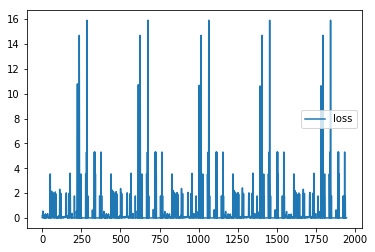

KeyboardInterrupt: 

In [517]:
from IPython.display import clear_output
e_losses = []
num_epochs = 20
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
    clear_output(True)
    plt.plot(e_losses,label='loss')
    plt.legend()
    plt.show()